In [ ]:
!pip install xgboost
!pip install scikit-learn
#!pip install sklearn

Requirement already satisfied: xgboost in /databricks/python3/lib/python3.8/site-packages (1.6.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.21.4)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.7.3)
 WARNING: You are using pip version 22.0.3; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python3.8 -m pip install --upgrade pip' command. 
 Requirement already satisfied: sklearn in /databricks/python3/lib/python3.8/site-packages (0.0)
Requirement already satisfied: scikit-learn in /databricks/python3/lib/python3.8/site-packages (from sklearn) (1.0.2)
Requirement already satisfied: numpy>=1.14.6 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn->sklearn) (1.21.4)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn->sklearn) (3.1.0)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn->sklearn) (1.1.0)
Requirement already satisfied: scipy>=1.1.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn->sklearn) (1.7.3)
 WARNING: You are using pip version 22.0.3; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python3.8 -m pip install --upgrade pip' command.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
# Read Files and Column Explantion
# Class: Model target, 1 means it's a credit card fraud, otherwise 0
# Time: Seconds elapsed between each transaction and the first transaction in the dataset
# Amount: Credit card transaction amount
# featuer_1-featuer_7: other model inputs
path = '/dbfs/FileStore/qm/shenan/creditcard_interview.csv'
df = pd.read_csv(path)
print(df.shape)
df.head(5)

(14708, 10)
Out[4]:

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,0,162183.0,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.471390,0.741141
1,0,120967.0,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,NaN,-0.838932
2,0,26484.0,1937.66,1.457844,-0.899347,-6.059393,-1.784000,0.484257,-4.171672,1.195815
3,0,65751.0,320.05,-0.401365,-0.282106,-0.583587,1.345463,-1.038179,0.252497,-0.761357
4,0,137025.0,11.50,0.481656,-1.568433,3.699527,-0.296621,0.679977,-0.455964,0.534602


In [ ]:
# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis. 
# Therefore they are excluded from the model development 
X = df[['Time', 'Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10295, 7)
y_train shape: (10295,)
X_test shape: (4413, 7)
y_test shape: (4413,)

In [ ]:
# Hyperparameter Tuning
cv_params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 500, 1000]}    # candidate parameter
fix_params = {'objective': 'binary:logistic', 'eval_metric':'logloss'}   # other parameters
cv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring='roc_auc', cv=3)
cv.fit(X_train, y_train)
cv.best_params_

Out[6]: {'learning_rate': 0.1, 'n_estimators': 500}

In [ ]:
best_params = {'learning_rate':0.1, 'n_estimators':500, 'objective':'binary:logistic', 'eval_metric':'logloss'}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

Out[7]: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
 early_stopping_rounds=None, enable_categorical=False,
 eval_metric='logloss', gamma=0, gpu_id=-1,
 grow_policy='depthwise', importance_type=None,
 interaction_constraints='', learning_rate=0.1, max_bin=256,
 max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
 min_child_weight=1, missing=nan, monotone_constraints='()',
 n_estimators=500, n_jobs=0, num_parallel_tree=1, predictor='auto',
 random_state=0, reg_alpha=0, reg_lambda=1, ...)

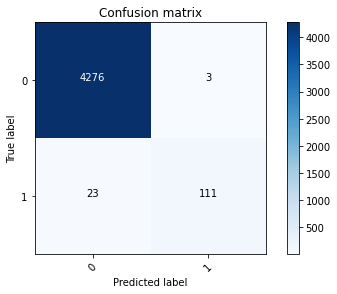

Precision = 0.974
Recall (TPR) = 0.828
Fallout (FPR) = 7.011e-04

In [ ]:
# Predict Model and set threshold to 0.5
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [ ]:
# Save the Model
# Please Ignore the path
model.save_model('/.../interview_model_object')

In [ ]:
### Codes to load the model object
model_load = xgb.XGBClassifier()
model_load.load_model('/.../interview_model_object')
y_pred = model_load.predict(X_test)